

# ML Project: Customer Spending Score



In [ ]:
# Names: Rahul Maligi, Ben Gonzales, Macy Huang, Tiffany Kao

#Data Preprocessing


Data Cleaning and Exploration


In [ ]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import seaborn
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline


In [ ]:
#import dataset, and show head
df = pd.read_csv('Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


#Data Exploration

In [ ]:
#How many missing values do we have?
print("Missing values in Gender: ", (df['Gender'] == 0).sum())
print("Missing values in Age: ", (df['Age'] == 0).sum())
print("Missing values in Annual Income: ", (df['Annual Income ($)'] == 0).sum())
print("Missing values in Spending Score: ", (df['Spending Score (1-100)'] == 0).sum())
print("Missing values in Profession: ", (df['Profession'] == 0).sum())
#note for Work experience, some people have 0 years of experience and some are missing values
#This will be determined in the next few cells
print("Missing values in Work Experience: ", (df['Work Experience'] == 0).sum())
print("Missing values in Family Size: ", (df['Family Size'] == 0).sum())

Missing values in Gender:  0
Missing values in Age:  24
Missing values in Annual Income:  2
Missing values in Spending Score:  2
Missing values in Profession:  0
Missing values in Work Experience:  431
Missing values in Family Size:  0


In [ ]:
#Imputation for Profession
#replace 0s with nan for the rest of the data set
#Use forward fill 
df.replace(0,np.nan, inplace=True)
df["Profession"].ffill(inplace=True)
df.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19.0,15000.0,39.0,Healthcare,1.0,4
1,2,Male,21.0,35000.0,81.0,Engineer,3.0,3
2,3,Female,20.0,86000.0,6.0,Engineer,1.0,1
3,4,Female,23.0,59000.0,77.0,Lawyer,NaN,2
4,5,Female,31.0,38000.0,40.0,Entertainment,2.0,6


In [ ]:
#Imputation for Work experience
#fill in with the median for Profession group
ex_maps = {}
for i in df.groupby('Profession')['Work Experience']:
    ex_maps[i[0]] = i[1].median()
df['Work Experience'] = df['Work Experience'].fillna(df['Profession'].map(ex_maps))
df.head(20)

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19.0,15000.0,39.0,Healthcare,1.0,4
1,2,Male,21.0,35000.0,81.0,Engineer,3.0,3
2,3,Female,20.0,86000.0,6.0,Engineer,1.0,1
3,4,Female,23.0,59000.0,77.0,Lawyer,4.0,2
4,5,Female,31.0,38000.0,40.0,Entertainment,2.0,6
5,6,Female,22.0,58000.0,76.0,Artist,5.0,2
6,7,Female,35.0,31000.0,6.0,Healthcare,1.0,3
7,8,Female,23.0,84000.0,94.0,Healthcare,1.0,3
8,9,Male,64.0,97000.0,3.0,Engineer,5.0,3
9,10,Female,30.0,98000.0,72.0,Artist,1.0,4


In [ ]:
#Since there are very few missing values in Annual Income and Spending score
#we can drop them
df = df[df['Annual Income ($)'] > 0]
df = df[df['Spending Score (1-100)'] > 0]

#Missing values in ages will be imputed
#Fill in with the median age of the person's Profession category
age_maps = {}
for i in df.groupby('Profession')['Age']:
    age_maps[i[0]] = i[1].median()
df['Age'] = df['Age'].fillna(df['Profession'].map(age_maps))
df.head(20)
# print("Missing values in Age: ", (np.isnan(df['Age'])).sum())

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19.0,15000.0,39.0,Healthcare,1.0,4
1,2,Male,21.0,35000.0,81.0,Engineer,3.0,3
2,3,Female,20.0,86000.0,6.0,Engineer,1.0,1
3,4,Female,23.0,59000.0,77.0,Lawyer,4.0,2
4,5,Female,31.0,38000.0,40.0,Entertainment,2.0,6
5,6,Female,22.0,58000.0,76.0,Artist,5.0,2
6,7,Female,35.0,31000.0,6.0,Healthcare,1.0,3
7,8,Female,23.0,84000.0,94.0,Healthcare,1.0,3
8,9,Male,64.0,97000.0,3.0,Engineer,5.0,3
9,10,Female,30.0,98000.0,72.0,Artist,1.0,4


In [ ]:
#Correlation Matrix
df.corr()

<ipython-input-57-025dc37326d1>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,CustomerID,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
CustomerID,1.000000,0.072588,0.325392,0.017925,0.075995,0.161185
Age,0.072588,1.000000,0.022146,-0.037727,0.000828,0.042727
Annual Income ($),0.325392,0.022146,1.000000,0.023987,0.069951,0.093419
Spending Score (1-100),0.017925,-0.037727,0.023987,1.000000,-0.031378,0.005291
Work Experience,0.075995,0.000828,0.069951,-0.031378,1.000000,0.015472
Family Size,0.161185,0.042727,0.093419,0.005291,0.015472,1.000000


The correlation matrix shows that all of the features have incredibly
low correlation.  First we will take a closer look at our inital data,
to see if we can find any trends or reasons for such low correlation.
Later some feature engineering will be implemented in hopes of improvement.
However, because the inital dataset used has such low correlation,
The accuracies of our models are also impacted. 

<Axes: title={'center': 'Profession Distribution'}>

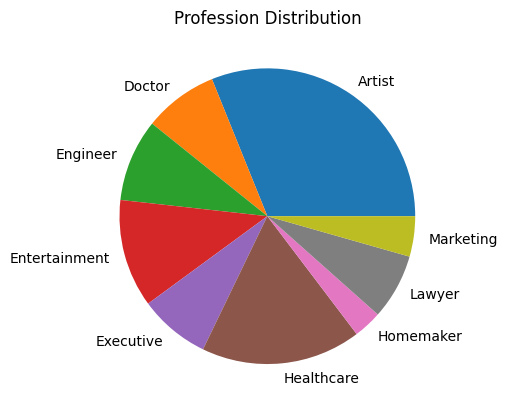

In [ ]:
#Distribution of Professions
occ = df.groupby('Profession')
occ.size().plot.pie(title='Profession Distribution')
plt.show()

The most common Profession is Artist, followed by Healthcare and Entertainment.  The data seems to be fairly well distruibuted.  

<Axes: title={'center': 'Annual Income Distribution'}, ylabel='Dollars per Year'>

The average income is:  110891.10370741483


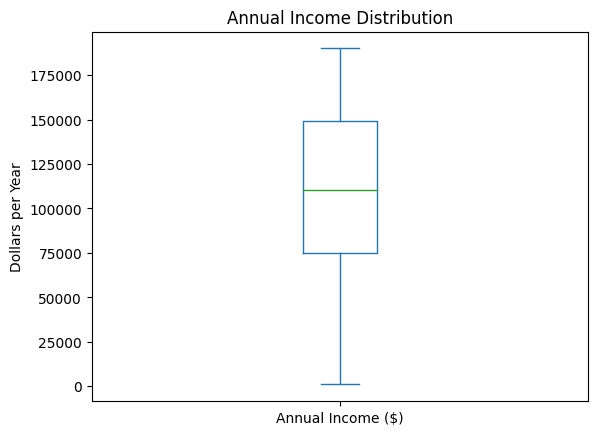

In [ ]:
#Outliers?  Income
income = df['Annual Income ($)']
income.plot(kind='box', title='Annual Income Distribution', 
ylabel='Dollars per Year')

print("The average income is: ", income.mean())

According to the box plot, there are no discernable outliers, and the average income is around 110891.  


<Axes: title={'center': 'Family Size Distribution'}, xlabel='Size', ylabel='Amount of people'>

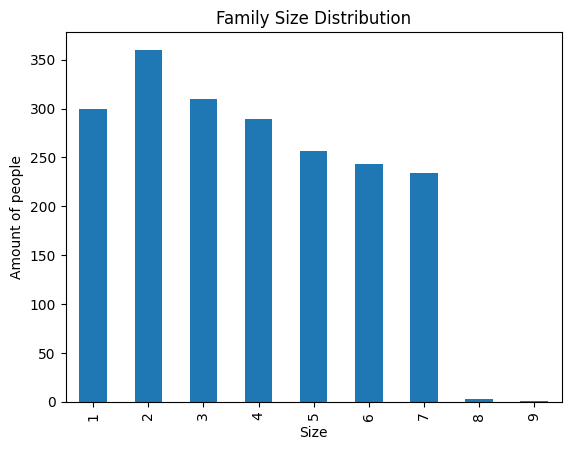

In [ ]:
#Distribution of Family Sizes
#Family size of 9 would be a natural outlier
amount = df.groupby('Family Size').size()
ages = df['Family Size'].unique()
amount.plot(kind='bar', title='Family Size Distribution', xlabel = 'Size', 
ylabel='Amount of people')
plt.show()


There is a reasonably even distribution of family sizes.  A family size of 9 could be considered a natural outlier, but we chose to leave it in as it doesn't have much of an effect on spending score.

<ipython-input-61-36e6118006a9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hundred['Spending Score (1-100)'].replace(['<=50', '>50'],


<Axes: title={'center': 'Age and Income Effects on Spending Score'}, xlabel='Age', ylabel='Annual Income ($)'>

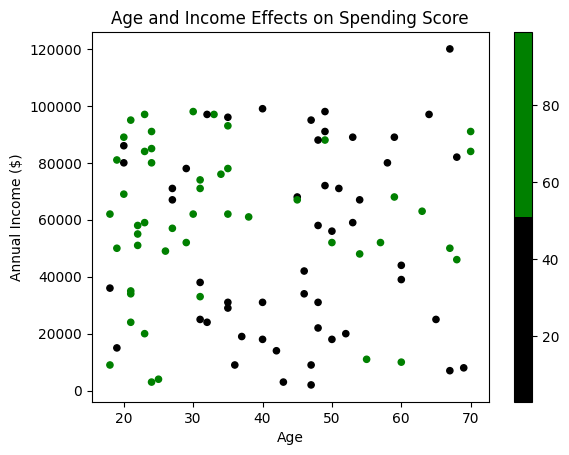

In [ ]:
#Compare and graph income, age, and spending score
hundred = df.head(100)
incomes = hundred.groupby('Spending Score (1-100)')

#Spending scores above 50 are green, below and including are black
hundred['Spending Score (1-100)'].replace(['<=50', '>50'],
                        [0, 1], inplace=True)
#plt.title("Age and Income Effects on Spending Score")
hundred.plot.scatter(x='Age', y='Annual Income ($)', 
                     title = "Age and Income Effects on Spending Score",
                     c=hundred['Spending Score (1-100)'],
            cmap = mcolors.ListedColormap(["black", "green"]))


No discernable pattern between age, income, and spending score.
I thought there'd be a bit of correlation between age and income, however there does not appear to be a pattern of any sort.  

#Feature Engineering

We decided to bin some of the features to see if they would be easier to predict as categorical features instead of numerical ones. This allowed us to use the same accuracy metric across our models. For the sake of experimentation, we also converted Spending Score, our target variable, using a few bin sizes.

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of Annual Income')

Text(0.5, 0, 'Income ($)')

Text(0, 0.5, 'Number of Customers')

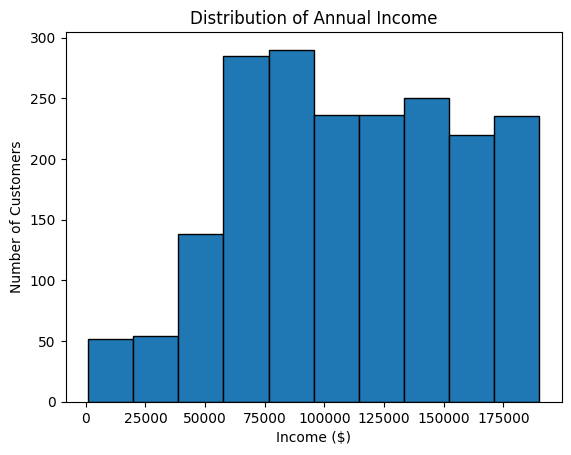

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of Binned Income')

Text(0.5, 0, 'Assigned Income Bin')

Text(0, 0.5, 'Number of Customers')

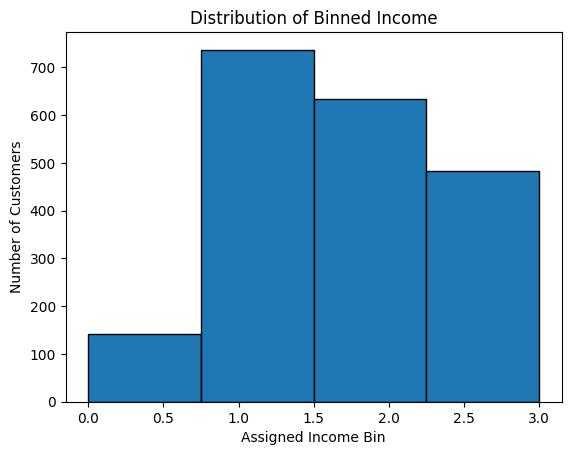

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of Age')

Text(0.5, 0, 'Age (years)')

Text(0, 0.5, 'Number of Customers')

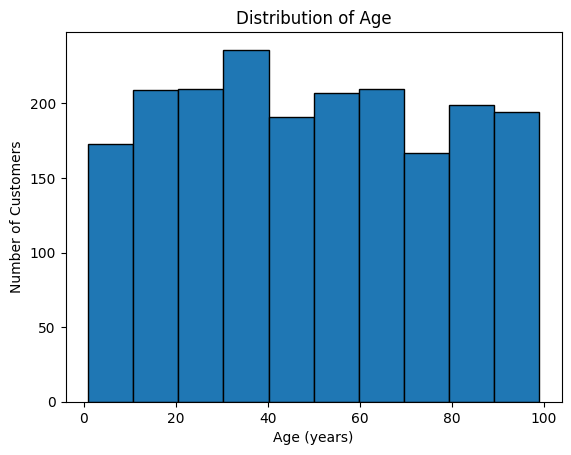

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of Binned Age')

Text(0.5, 0, 'Assigned Age Bin')

Text(0, 0.5, 'Number of Customers')

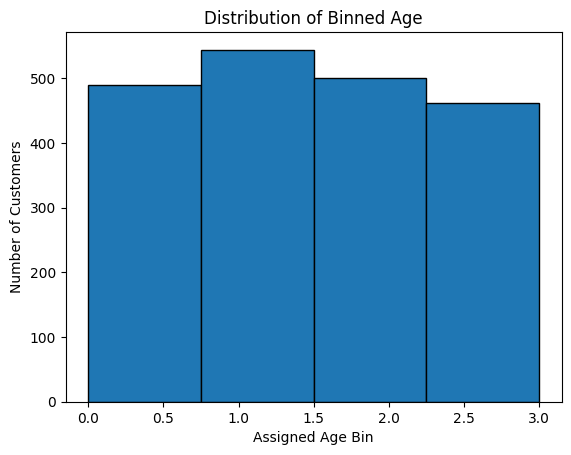

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size,Binned Income,Binned Age,SS2,SS4,SS5,SS10
0,1,Male,19,15000,39,Healthcare,1.0,4,0,0,0,1,1,3
1,2,Male,21,35000,81,Engineer,3.0,3,0,0,1,3,4,8
2,3,Female,20,86000,6,Engineer,1.0,1,1,0,0,0,0,0
3,4,Female,23,59000,77,Lawyer,4.0,2,1,0,1,3,3,7
4,5,Female,31,38000,40,Entertainment,2.0,6,0,1,0,1,1,3


In [ ]:
# bin age, income, and spending score
df['Annual Income ($)'] = df['Annual Income ($)'].astype('int')
df['Annual Income ($)'].plot(kind="hist", edgecolor="black", grid=False)
plt.title("Distribution of Annual Income")
plt.xlabel("Income ($)")
plt.ylabel("Number of Customers")
plt.show()
bins=[50000 * x for x in range(5)]
df['Binned Income'] = pd.cut(df['Annual Income ($)'], bins, labels=False)
df['Binned Income'].plot(kind="hist", edgecolor="black", bins=4, grid=False)
plt.title("Distribution of Binned Income")
plt.xlabel("Assigned Income Bin")
plt.ylabel("Number of Customers")
plt.show()

#Bins for Age
df['Age'] = df['Age'].astype('int')
df['Age'].plot(kind="hist", edgecolor="black", grid=False)
plt.title("Distribution of Age")
plt.xlabel("Age (years)")
plt.ylabel("Number of Customers")
plt.show()
df['Binned Age'] = pd.cut(df['Age'], bins=[0, 25, 50, 75, 100], labels=False)
df['Binned Age'].plot(kind="hist", edgecolor="black", bins=4, grid=False)
plt.title("Distribution of Binned Age")
plt.xlabel("Assigned Age Bin")
plt.ylabel("Number of Customers")
plt.show()

#Bins for spending score
df['Spending Score (1-100)'] = df['Spending Score (1-100)'].astype('int')
df['SS2'] = pd.cut(df['Spending Score (1-100)'], bins=[0, 50, 100], labels=False)
df['SS4'] = pd.cut(df['Spending Score (1-100)'], bins=[0, 25, 50, 75, 100], labels=False)
df['SS5'] = pd.cut(df['Spending Score (1-100)'], bins=[0, 20, 40, 60, 80, 100], labels=False)
df['SS10'] = pd.cut(df['Spending Score (1-100)'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=False)
df.head()

There were a few changes we had to make to the data - a couple features were composed of categorical data so we one-hot encoded them. The customer ID feature is just metadata and has no impact on an assigned spending score we also decided to drop it. 

In [ ]:
# Drop irrelevant features, one-hot encode categorical features
# List of categorical data needed to be encoded
categorical_data = ["Profession", "Gender"]
# Encode data
transformer = make_column_transformer((OneHotEncoder(), categorical_data), remainder = 'passthrough')
transformed = transformer.fit_transform(df)
# Create transformed df
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
# Drop customer id
transformed_df = transformed_df.drop("remainder__CustomerID", axis=1)
# separate features from label
features = transformed_df.drop(["remainder__Spending Score (1-100)", "remainder__SS2", "remainder__SS4", "remainder__SS5", "remainder__SS10"], axis=1)

# trying out different labels/binning
labels = transformed_df["remainder__Spending Score (1-100)"].values.ravel()
labels_ss2 = transformed_df["remainder__SS2"].values.ravel()
labels_ss4 = transformed_df["remainder__SS4"].values.ravel()
labels_ss5 = transformed_df["remainder__SS5"].values.ravel()
labels_ss10 = transformed_df["remainder__SS10"].values.ravel()
labels_list = [labels_ss2, labels_ss4, labels_ss5, labels_ss10, labels]
# take a look at transformed data
transformed_df.head()

,onehotencoder__Profession_Artist,onehotencoder__Profession_Doctor,onehotencoder__Profession_Engineer,onehotencoder__Profession_Entertainment,onehotencoder__Profession_Executive,onehotencoder__Profession_Healthcare,onehotencoder__Profession_Homemaker,onehotencoder__Profession_Lawyer,onehotencoder__Profession_Marketing,onehotencoder__Gender_Female,...,remainder__Annual Income ($),remainder__Spending Score (1-100),remainder__Work Experience,remainder__Family Size,remainder__Binned Income,remainder__Binned Age,remainder__SS2,remainder__SS4,remainder__SS5,remainder__SS10
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,15000.0,39.0,1.0,4.0,0.0,0.0,0.0,1.0,1.0,3.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,35000.0,81.0,3.0,3.0,0.0,0.0,1.0,3.0,4.0,8.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,86000.0,6.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,59000.0,77.0,4.0,2.0,1.0,0.0,1.0,3.0,3.0,7.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,38000.0,40.0,2.0,6.0,0.0,1.0,0.0,1.0,1.0,3.0


Plotting a histogram of our target variable, Spending Score, we decided that the data did not show significant imbalances in the Spending Score continuum. For this reason, we decided scaling and conducting a PCA would be sufficient for making overall data adjustments and transforming it with SMOTE would not significantly affect our results.

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of Spending Score')

Text(0.5, 0, 'Spending Score')

Text(0, 0.5, 'Number of Customers')

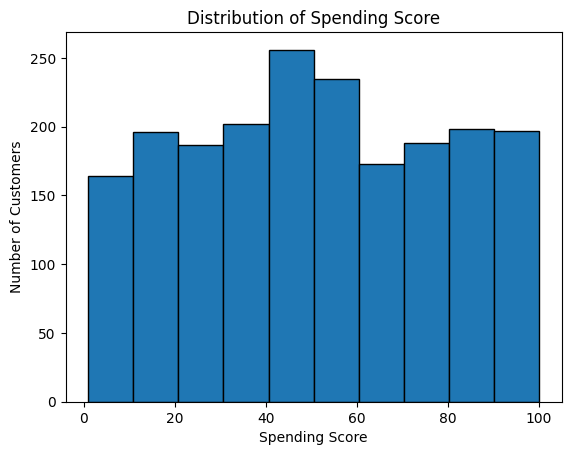

In [ ]:
# make histogram of spending score to see if there's any imbalance (which would necessitate SMOTE)
transformed_df['remainder__Spending Score (1-100)'] = transformed_df['remainder__Spending Score (1-100)'].astype('int')
transformed_df['remainder__Spending Score (1-100)'].plot(kind="hist", edgecolor="black", grid=False)
plt.title("Distribution of Spending Score")
plt.xlabel("Spending Score")
plt.ylabel("Number of Customers")

# spending score distribution is not terribly imbalanced, will just scale and conduct a PCA on the data before training our models

Following that, there were a few ways we decided to analyze the features for what the most and least significant features were. These methods included K-means Clustering, random forest classification, ANOVA tests (to select the best features), and recursive feature elimination. 

Our intuition was that income and family size should have some relationship with the amount a customer would spend and therefore impact the assigned Spending Score, but as seen in our correlation matrix earlier though, all of our features were generally uncorrelated -- with the Spending Score and with other features. Ultimately, since the methods produced inconsistent "best features" to keep, we decided not to drop any features.

In [ ]:
# Using kmeans clustering to do some unsupervised feature analysis
# split dataset into train and test
transformed_df['remainder__Age'] = transformed_df['remainder__Age'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(features, transformed_df.iloc[:, 13])

# scale, PCA data before performing clustering
scaler = StandardScaler()
pca = PCA(n_components=.95, svd_solver='full')
# kmeans++ to avoid cases in which kmeans is initiated strangely and converges inconsistently
km = KMeans(n_clusters=10, init='k-means++', random_state=11)

pipeline = Pipeline([('scaler', scaler), ('pca', pca), ('km', km)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# bin spending score for a better idea of whether our models can predict it accurately based on the current version of our data
y_test = pd.cut(y_test, bins=10, labels=False)

# compare kmeans clustering assignments vs actual data's spending score bins
print(np.count_nonzero(y_pred==y_test) / len(y_test))

centroids = pipeline.named_steps['km'].cluster_centers_

# see what the most important features are for each cluster
for i in range(len(centroids)):
    print('cluster ' + str(i) + ' : centroid = ' + str(centroids[i]))
    print('top 5 features:')
    sorted_features = sorted(range(12), key=lambda k: centroids[i][k], reverse=True)
    for j in sorted_features[:5]:
        print(str(X_train.columns[j]))
    print()

    # print how much cluster associates with a spending score bin
    indices = (y_pred == i)
    predictions = y_test[indices]
    print('cluster ' + str(i) + ': \n' + str(predictions.value_counts(normalize=True)))



/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95, svd_solver='full')),
                ('km', KMeans(n_clusters=10, random_state=11))])

0.09018036072144289
cluster 0 : centroid = [ 1.08159217 -0.61592453 -0.5778952   1.54458602  0.18489959 -0.30938136
 -0.08241212  0.0647847  -0.02629171 -0.02713025 -0.04190144  0.03534705
 -0.00609422]
top 5 features:
onehotencoder__Profession_Entertainment
onehotencoder__Profession_Artist
onehotencoder__Profession_Executive
onehotencoder__Profession_Lawyer
remainder__Age

cluster 0: 
9    0.141414
4    0.131313
3    0.131313
1    0.121212
5    0.090909
6    0.090909
2    0.080808
0    0.080808
7    0.070707
8    0.060606
Name: remainder__Spending Score (1-100), dtype: float64
cluster 1 : centroid = [-0.27486674  0.12993387 -0.05049623 -1.17076855  1.69428191 -0.68053601
 -0.88178118  0.18235654 -0.06231458 -0.1003562  -0.05850688 -0.38597077
 -0.05707412]
top 5 features:
onehotencoder__Profession_Executive
onehotencoder__Profession_Lawyer
onehotencoder__Profession_Doctor
onehotencoder__Profession_Engineer
onehotencoder__Gender_Male

cluster 1: 
5    0.147727
2    0.125000
3    0.1250

Interestingly, the numeric annual income/age are more important than the binned income and age and Profession is hardly significant at all. If we had to pick the method that selected important features most accurately, it would probably be this random forest classifier, since it appears to be most consistent with our hypothesized features of most importance.

In [ ]:
# rank important features using a random forest classifier
rfc = RandomForestClassifier(n_estimators=60)
rfc.fit(X_train, y_train)
ft_imp = rfc.feature_importances_
indices = np.argsort(ft_imp)[::-1]
print(indices)

for f in range(15):
    print('feature: '  + str(X_train.columns[indices[f]]) + ', importance: ' + str(ft_imp[indices[f]]))

RandomForestClassifier(n_estimators=60)

[12 11 13 14 16 15  0 10  9  5  3  2  1  4  7  8  6]
feature: remainder__Annual Income ($), importance: 0.22429124318961347
feature: remainder__Age, importance: 0.20331110264279315
feature: remainder__Work Experience, importance: 0.14078898132904188
feature: remainder__Family Size, importance: 0.13293975641452316
feature: remainder__Binned Age, importance: 0.06164311165156556
feature: remainder__Binned Income, importance: 0.055848576651914915
feature: onehotencoder__Profession_Artist, importance: 0.02470126037304925
feature: onehotencoder__Gender_Male, importance: 0.022835313006708536
feature: onehotencoder__Gender_Female, importance: 0.02275576123743723
feature: onehotencoder__Profession_Healthcare, importance: 0.019827495017611177
feature: onehotencoder__Profession_Entertainment, importance: 0.01743243352039661
feature: onehotencoder__Profession_Engineer, importance: 0.01593099076259067
feature: onehotencoder__Profession_Doctor, importance: 0.01390920488839934
feature: onehotencoder_

When we used scikit-learn's feature selection/elimination tools, results were very different. Our one-hot encoding of the profession and gender categories resulted in fracturings within the category where some professions or genders might be selected as important features, but others would not. However, with a category like gender, where the assignment was mutually exclusively male or female, we would expect both features to be selected.

In [ ]:
num_features = 8

# use anova test to choose best k features
sel = SelectKBest(score_func=f_classif, k=num_features).fit(X_train, y_train)
sel_indices = sel.get_support(indices=True)

print('selector features:', X_train.columns[sel_indices])

# recursive feature elim
rfe = RFE(LogisticRegression(), n_features_to_select=num_features).fit(X_train, y_train)
rfe_indices = rfe.get_support(indices=True)
print(' features:', X_train.columns[rfe_indices])

selector features: Index(['onehotencoder__Profession_Doctor',
       'onehotencoder__Profession_Entertainment',
       'onehotencoder__Profession_Executive',
       'onehotencoder__Profession_Healthcare',
       'onehotencoder__Profession_Homemaker', 'remainder__Age',
       'remainder__Annual Income ($)', 'remainder__Binned Income'],
      dtype='object')


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

 features: Index(['onehotencoder__Profession_Doctor',
       'onehotencoder__Profession_Engineer',
       'onehotencoder__Profession_Entertainment',
       'onehotencoder__Profession_Executive',
       'onehotencoder__Profession_Healthcare',
       'onehotencoder__Profession_Homemaker',
       'onehotencoder__Profession_Lawyer',
       'onehotencoder__Profession_Marketing'],
      dtype='object')


Looking at the correlation matrix of our transformed data one last time before scaling it, the low correlation between elements of our data is very evident. There are some very faintly orange or blue squares in our data, but it can't say anything very interesting about relationships in our data.

<Axes: >

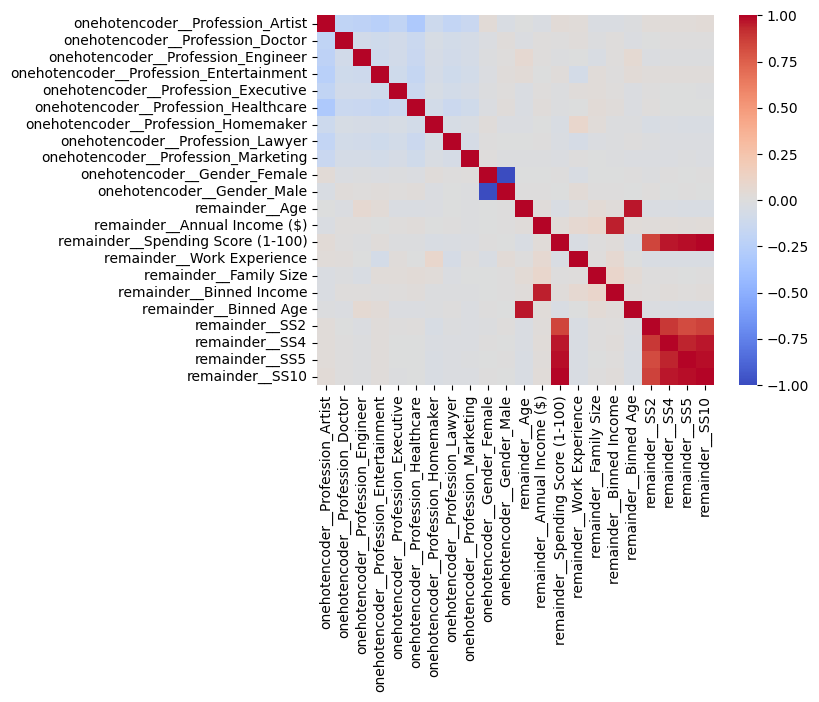

In [ ]:
# heat maps, correlation matrices
corr_matrix = transformed_df.corr()
seaborn.heatmap(corr_matrix, cmap='coolwarm')

Seeing that our feature selection methods produced varying results, we decided not to drop anything. We also determined that there weren't any features we should create from our limited data - without any information about how or where the data was collected either (e.g. knowing the location of the shop so we could compare CPI, average wealth of the area, etc.), we could not bring in new information and create more relevant features. Instead, we scaled the data and applied a PCA to hopefully reduce noise and error.

In [ ]:
# scale, PCA data
scaler = StandardScaler()
scaler.fit(features)
scaled_data = scaler.transform(features)
scaled_df = pd.DataFrame(scaled_data)

pca = PCA(n_components=.95, svd_solver='full')
pca_data = pca.fit_transform(scaled_df)
print(pca_data.shape)
scaled_df = pd.DataFrame(pca_data)
print(scaled_df)

StandardScaler()

(1996, 13)
            0         1         2         3         4         5         6   \
0     2.130735  2.885995  1.051812 -1.371184  1.483670 -1.482049 -0.387244   
1     1.736393  2.640013  1.236816 -0.656372 -0.623781  1.137518 -1.841772   
2     2.147514 -0.176938 -0.226089 -0.821835 -1.009815  1.022693 -2.446636   
3     2.532470 -0.043121 -0.195738 -0.891720 -1.199084 -0.058120 -1.744983   
4     2.362497 -0.261245  1.185595 -1.361129 -1.718772 -1.470922  1.698294   
...        ...       ...       ...       ...       ...       ...       ...   
1991 -1.507834 -2.006411 -1.222468  1.719023  0.431118 -0.223384  0.640797   
1992 -0.246878 -1.530636  1.757640 -0.699305  0.274766  1.538787  0.791018   
1993 -1.378806  1.063530  2.022570 -0.768594  2.225408 -0.451161 -0.286361   
1994 -3.080658  0.531386 -0.232191 -0.094655 -0.158635  1.380339  0.965481   
1995 -2.104874  0.676118  1.680862 -0.604043 -1.719544 -1.035418  0.986444   

            7         8         9         10        

#Models


##Model 1: Linear Regression

Firstly, we run linear regression as a baseline model because of its simplicity and speed. The R-squared value is a great preliminary statistical measure that gives us a general idea of how much of the variance of the spending scores can be captured by the features. 


In [ ]:
#spending score
#ben
num_bins = ['2 bins', '4 bins', '5 bins', '10 bins', 'No bins']
def linear_regression(_features):
    for i in range(len(labels_list)):
        
        # reserve 30% of data for testing
        X_train, X_test, y_train, y_test = train_test_split(_features, labels_list[i], test_size=0.3)

        # fit a linear regression model to the training data
        linear_regression = LinearRegression()
        linear_regression.fit(X_train, y_train)

        # evaluation
        y_pred = linear_regression.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(num_bins[i])
        print("MSE:", mse)
        print("MAE:", mae)
        print("R-squared:", r2)
        print()

# without scaled data
print("Without scaled data:")
linear_regression(features)

# with scaled data
print("With scaled data:")
linear_regression(scaled_df)

Without scaled data:
2 bins
MSE: 0.2541121077493049
MAE: 0.5013926620849565
R-squared: -0.016473927763811513

4 bins
MSE: 1.2534676728624263
MAE: 0.9957899135901477
R-squared: -0.012488697586912734

5 bins
MSE: 1.8211562327206043
MAE: 1.1168704929516224
R-squared: -0.017494102218296614

10 bins
MSE: 7.973386501567941
MAE: 2.3815511976557207
R-squared: -0.016868930884011535

No bins
MSE: 776.5330589496448
MAE: 23.96378682356987
R-squared: -0.017232016555937868

With scaled data:
2 bins
MSE: 0.2504786444861191
MAE: 0.49899501814462904
R-squared: -0.0020514240507538695

4 bins
MSE: 1.2122238574275384
MAE: 0.9741673696539837
R-squared: -0.01613665140841558

5 bins
MSE: 1.95255794850599
MAE: 1.1744035362159684
R-squared: -0.009399449730133735

10 bins
MSE: 7.551783948094921
MAE: 2.338033918389741
R-squared: -0.0030732148911316592

No bins
MSE: 752.7339238981886
MAE: 23.224442421010334
R-squared: -0.011035872220664267



The model performed very poorly. The R-squared values are near zero or below zero with high MSE values. 

##Model 2: Naive Bayes

Next, we use another simple and fast model before moving towards more complicated models. Naive Bayes works well with high-dimensional data. This time we use a classification approach instead of a regressor to predict the data. 

In [ ]:
#ben
def naive_bayes(_features):
    for i in range(len(labels_list)):
        # reserve 30% of data for testing
        X_train, X_test, y_train, y_test = train_test_split(_features, labels_list[i], test_size=0.3)

        # fit a naive bayes model to the training data
        gnb = GaussianNB()
        gnb.fit(X_train, y_train)

        # evaluate the performance
        y_pred = gnb.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)

        print(num_bins[i])
        print("Accuracy:", accuracy)
        print("MSE:", mse)
        print("MAE:", mae)
        print("Classification Report:", class_report)

# without scaled data
print("Without scaled data:")
naive_bayes(features)

# with scaled data
print("With scaled data:")
naive_bayes(scaled_df)

Without scaled data:
2 bins
Accuracy: 0.4941569282136895
MSE: 0.5058430717863105
MAE: 0.5058430717863105
Classification Report:               precision    recall  f1-score   support

         0.0       0.52      0.42      0.46       315
         1.0       0.47      0.58      0.52       284

    accuracy                           0.49       599
   macro avg       0.50      0.50      0.49       599
weighted avg       0.50      0.49      0.49       599

4 bins
Accuracy: 0.2570951585976628
MSE: 1.8030050083472453
MAE: 1.0717863105175292
Classification Report:               precision    recall  f1-score   support

         0.0       0.10      0.01      0.02       144
         1.0       0.26      0.54      0.35       159
         2.0       0.21      0.21      0.21       149
         3.0       0.37      0.23      0.28       147

    accuracy                           0.26       599
   macro avg       0.23      0.25      0.22       599
weighted avg       0.23      0.26      0.22       599

5 b

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

5 bins
Accuracy: 0.20534223706176963
MSE: 3.7529215358931554
MAE: 1.5459098497495827
Classification Report:               precision    recall  f1-score   support

         0.0       0.15      0.08      0.11       106
         1.0       0.11      0.05      0.06       111
         2.0       0.24      0.34      0.28       145
         3.0       0.22      0.19      0.20       109
         4.0       0.20      0.30      0.24       128

    accuracy                           0.21       599
   macro avg       0.18      0.19      0.18       599
weighted avg       0.19      0.21      0.19       599

10 bins
Accuracy: 0.11853088480801335
MSE: 18.31719532554257
MAE: 3.4457429048414023
Classification Report:               precision    recall  f1-score   support

         0.0       0.09      0.15      0.11        46
         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00        56
         3.0       0.14      0.08      0.10        63
         4.0       0.12 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model performed nearly the same as linear regression and KNN.

##Model 3: KNN

Next, we choose to use KNN as it may work better with data that is not linearly separable. Additionally, it’s quite good at filtering out noise, resulting in more accurate predictions. 

In [ ]:
KNeighborsClassifier,
#ben
def knn(_features):
    for i in range(len(labels_list)):
        # reserve 30% of the data for testing
        X_train, X_test, y_train, y_test = train_test_split(_features, labels_list[i], test_size=0.3)

        # check k values for 1-20 for the best prediction
        best_k = -1
        best_mse = float('inf')
        for k in range(1, 21):

            # fit knn model to training data
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)

            # evaluate its performance
            y_pred = knn.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            if mse < best_mse:
                best_k = k
                best_mse = mse
                best_mae = mae
                best_class_report = classification_report(y_test, y_pred, output_dict=True)

        print(num_bins[i])
        print("Most accurate k:", best_k)
        print("MSE:", best_mse)
        print("MAE:", best_mae)
        print("Classification Report:", best_class_report)
        print()

# without scaled data
print("Without scaled data:")
knn(features)

# with scaled data
print("With scaled data:")
knn(scaled_df)

(sklearn.neighbors._classification.KNeighborsClassifier,)

Without scaled data:
2 bins
Most accurate k: 9
MSE: 0.46410684474123537
MAE: 0.46410684474123537
Classification Report: {'0.0': {'precision': 0.5118343195266272, 'recall': 0.6048951048951049, 'f1-score': 0.5544871794871794, 'support': 286}, '1.0': {'precision': 0.5670498084291188, 'recall': 0.4728434504792332, 'f1-score': 0.5156794425087108, 'support': 313}, 'accuracy': 0.5358931552587646, 'macro avg': {'precision': 0.539442063977873, 'recall': 0.5388692776871691, 'f1-score': 0.5350833109979451, 'support': 599}, 'weighted avg': {'precision': 0.540686486515742, 'recall': 0.5358931552587646, 'f1-score': 0.53420867919626, 'support': 599}}

4 bins
Most accurate k: 1
MSE: 2.2454090150250416
MAE: 1.1903171953255425
Classification Report: {'0.0': {'precision': 0.30201342281879195, 'recall': 0.3284671532846715, 'f1-score': 0.3146853146853147, 'support': 137}, '1.0': {'precision': 0.21714285714285714, 'recall': 0.2360248447204969, 'f1-score': 0.2261904761904762, 'support': 161}, '2.0': {'precis

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMe

No bins
Most accurate k: 2
MSE: 1393.7111853088481
MAE: 30.07846410684474
Classification Report: {'1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, '2.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}, '3.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}, '4.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, '5.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5}, '6.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}, '7.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}, '8.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, '9.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}, '10.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, '11.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, '12.0': {'precision': 0.07692307692307693, 'recall': 0.16666666666666666, 'f1-score': 0.105263157

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

No bins
Most accurate k: 2
MSE: 1513.0467445742904
MAE: 32.12186978297162
Classification Report: {'1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, '2.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, '3.0': {'precision': 0.16666666666666666, 'recall': 0.09090909090909091, 'f1-score': 0.11764705882352942, 'support': 11}, '4.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, '5.0': {'precision': 0.1111111111111111, 'recall': 0.3333333333333333, 'f1-score': 0.16666666666666666, 'support': 3}, '6.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}, '7.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5}, '8.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, '9.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, '10.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}, '11.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}, '1

The model performed nearly the same as linear regression and naive bayes. 

##Model 4: Decision Tree

Before getting into more intensive models, we decided to experiment with how Decision Trees perform on the model since the past few have produced fairly low performance. Decision are quick and easy to create and test and provide a good baseline to predict how ensemble classifiers will perform.

In [ ]:
# iterate through bin sizes for outcome variable to see how model performs on
# different groupings of spending score
print("Without Scaled Data:")
for i in range(0, len(labels_list)):
    label = labels_list[i]
    print(["2 Bins", "4 Bins", "5 Bins", "10 Bins", "No Bins"][i])
    gridsearch = GridSearchCV(
        estimator = DecisionTreeClassifier(criterion='entropy'),
        param_grid = {
            'max_depth':(5, 10, 15, 20), 
            'min_samples_leaf':(5, 10, 15, 20), 
            'max_features':(5, 10, 15)
        },
        cv = 5,
        scoring = 'accuracy'
    )
    gridsearch.fit(features, label)
    y_predicted = cross_val_predict(gridsearch, features, label, cv=5)
    print("Best Params: ", gridsearch.best_params_)
    print("Best Accuracy: ", gridsearch.best_score_)
    print("MSE: ", mean_squared_error(label, y_predicted))
    print("MAE: ", mean_absolute_error(label, y_predicted))
    print("Classification Report: ", classification_report(label, y_predicted))
    print("Average Cross Val Score: ", cross_val_score(gridsearch, features, label, cv=10).mean())

# perform previous result using scaled and pca data
print("With Scaled Data:")
for i in range(0, len(labels_list)):
    label = labels_list[i]
    print(["2 Bins", "4 Bins", "5 Bins", "10 Bins", "No Bins"][i])
    gridsearch = GridSearchCV(
        estimator = DecisionTreeClassifier(criterion='entropy'),
        param_grid = {
            'max_depth':(5, 10, 15, 20), 
            'min_samples_leaf':(5, 10, 15, 20), 
            'max_features':(5, 10, 15)
        },
        cv = 5,
        scoring = 'accuracy'
    )
    gridsearch.fit(scaled_df, label)
    y_predicted = cross_val_predict(gridsearch, scaled_df, label, cv=5)
    print("Best Params: ", gridsearch.best_params_)
    print("Best Accuracy: ", gridsearch.best_score_)
    print("MSE: ", mean_squared_error(label, y_predicted))
    print("MAE: ", mean_absolute_error(label, y_predicted))
    print("Classification Report: ", classification_report(label, y_predicted))
    print("Average Cross Val Score: ", cross_val_score(gridsearch, scaled_df, label, cv=10).mean())

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': (5, 10, 15, 20),
                         'max_features': (5, 10, 15),
                         'min_samples_leaf': (5, 10, 15, 20)},
             scoring='accuracy')

Best Params:  {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 10}
Best Accuracy:  0.5120401002506266
MSE:  0.5170340681362725
MAE:  0.5170340681362725
Classification Report:                precision    recall  f1-score   support

         0.0       0.49      0.52      0.50      1005
         1.0       0.48      0.45      0.46       991

    accuracy                           0.48      1996
   macro avg       0.48      0.48      0.48      1996
weighted avg       0.48      0.48      0.48      1996

Average Cross Val Score:  0.4905301507537688


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': (5, 10, 15, 20),
                         'max_features': (5, 10, 15),
                         'min_samples_leaf': (5, 10, 15, 20)},
             scoring='accuracy')

Best Params:  {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 5}
Best Accuracy:  0.26553884711779446
MSE:  2.3231462925851702
MAE:  1.2029058116232465
Classification Report:                precision    recall  f1-score   support

         0.0       0.23      0.22      0.22       460
         1.0       0.28      0.38      0.32       545
         2.0       0.23      0.18      0.20       503
         3.0       0.25      0.22      0.24       488

    accuracy                           0.25      1996
   macro avg       0.25      0.25      0.25      1996
weighted avg       0.25      0.25      0.25      1996

Average Cross Val Score:  0.25953015075376884


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': (5, 10, 15, 20),
                         'max_features': (5, 10, 15),
                         'min_samples_leaf': (5, 10, 15, 20)},
             scoring='accuracy')

Best Params:  {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 20}
Best Accuracy:  0.2339598997493734
MSE:  2.8947895791583167
MAE:  1.3677354709418839
Classification Report:                precision    recall  f1-score   support

         0.0       0.16      0.09      0.11       360
         1.0       0.18      0.15      0.16       389
         2.0       0.24      0.54      0.33       491
         3.0       0.19      0.11      0.14       361
         4.0       0.18      0.08      0.11       395

    accuracy                           0.21      1996
   macro avg       0.19      0.19      0.17      1996
weighted avg       0.19      0.21      0.18      1996

Average Cross Val Score:  0.23047236180904523


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': (5, 10, 15, 20),
                         'max_features': (5, 10, 15),
                         'min_samples_leaf': (5, 10, 15, 20)},
             scoring='accuracy')

Best Params:  {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 20}
Best Accuracy:  0.12325814536340851
MSE:  12.664328657314629
MAE:  2.8947895791583167
Classification Report:                precision    recall  f1-score   support

         0.0       0.06      0.01      0.02       164
         1.0       0.07      0.03      0.04       196
         2.0       0.15      0.10      0.12       187
         3.0       0.09      0.08      0.08       202
         4.0       0.14      0.42      0.21       256
         5.0       0.12      0.16      0.13       235
         6.0       0.07      0.02      0.03       173
         7.0       0.08      0.05      0.07       188
         8.0       0.07      0.03      0.04       198
         9.0       0.09      0.11      0.10       197

    accuracy                           0.11      1996
   macro avg       0.09      0.10      0.08      1996
weighted avg       0.10      0.11      0.09      1996

Average Cross Val Score:  0.1197462311557789


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': (5, 10, 15, 20),
                         'max_features': (5, 10, 15),
                         'min_samples_leaf': (5, 10, 15, 20)},
             scoring='accuracy')

Best Params:  {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 15}
Best Accuracy:  0.016032581453634086
MSE:  1704.9298597194388
MAE:  33.61823647294589
Classification Report:                precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        18
         2.0       0.00      0.00      0.00        14
         3.0       0.00      0.00      0.00        21
         4.0       0.06      0.17      0.08        24
         5.0       0.00      0.00      0.00        14
         6.0       0.00      0.00      0.00        12
         7.0       0.00      0.00      0.00        13
         8.0       0.03      0.07      0.05        14
         9.0       0.00      0.00      0.00        12
        10.0       0.02      0.05      0.03        22
        11.0       0.00      0.00      0.00        15
        12.0       0.00      0.00      0.00        19
        13.0       0.02      0.12      0.04        17
        14.0       0.06      0.07      0.07        27
    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Cross Val Score:  0.015030150753768845


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': (5, 10, 15, 20),
                         'max_features': (5, 10, 15),
                         'min_samples_leaf': (5, 10, 15, 20)},
             scoring='accuracy')

Best Params:  {'max_depth': 15, 'max_features': 5, 'min_samples_leaf': 10}
Best Accuracy:  0.5165338345864662
MSE:  0.5210420841683366
MAE:  0.5210420841683366
Classification Report:                precision    recall  f1-score   support

         0.0       0.48      0.37      0.42      1005
         1.0       0.48      0.59      0.53       991

    accuracy                           0.48      1996
   macro avg       0.48      0.48      0.47      1996
weighted avg       0.48      0.48      0.47      1996

Average Cross Val Score:  0.4864824120603015


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': (5, 10, 15, 20),
                         'max_features': (5, 10, 15),
                         'min_samples_leaf': (5, 10, 15, 20)},
             scoring='accuracy')

Best Params:  {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 15}
Best Accuracy:  0.26704260651629075
MSE:  2.3777555110220443
MAE:  1.2344689378757514
Classification Report:                precision    recall  f1-score   support

         0.0       0.19      0.15      0.17       460
         1.0       0.26      0.41      0.32       545
         2.0       0.22      0.12      0.15       503
         3.0       0.23      0.23      0.23       488

    accuracy                           0.23      1996
   macro avg       0.22      0.23      0.22      1996
weighted avg       0.23      0.23      0.22      1996

Average Cross Val Score:  0.2424849246231156


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': (5, 10, 15, 20),
                         'max_features': (5, 10, 15),
                         'min_samples_leaf': (5, 10, 15, 20)},
             scoring='accuracy')

Best Params:  {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 5}
Best Accuracy:  0.23295739348370925
MSE:  2.8166332665330662
MAE:  1.339679358717435
Classification Report:                precision    recall  f1-score   support

         0.0       0.16      0.04      0.07       360
         1.0       0.21      0.07      0.10       389
         2.0       0.24      0.70      0.36       491
         3.0       0.31      0.02      0.05       361
         4.0       0.18      0.15      0.16       395

    accuracy                           0.23      1996
   macro avg       0.22      0.20      0.15      1996
weighted avg       0.22      0.23      0.16      1996

Average Cross Val Score:  0.21392964824120603


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': (5, 10, 15, 20),
                         'max_features': (5, 10, 15),
                         'min_samples_leaf': (5, 10, 15, 20)},
             scoring='accuracy')

Best Params:  {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 20}
Best Accuracy:  0.12574937343358394
MSE:  10.800100200400802
MAE:  2.687875751503006
Classification Report:                precision    recall  f1-score   support

         0.0       0.08      0.01      0.01       164
         1.0       0.11      0.12      0.12       196
         2.0       0.05      0.01      0.02       187
         3.0       0.07      0.03      0.04       202
         4.0       0.12      0.41      0.19       256
         5.0       0.12      0.31      0.17       235
         6.0       0.00      0.00      0.00       173
         7.0       0.06      0.02      0.03       188
         8.0       0.14      0.01      0.02       198
         9.0       0.08      0.02      0.03       197

    accuracy                           0.11      1996
   macro avg       0.08      0.09      0.06      1996
weighted avg       0.09      0.11      0.07      1996

Average Cross Val Score:  0.11021608040201006


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': (5, 10, 15, 20),
                         'max_features': (5, 10, 15),
                         'min_samples_leaf': (5, 10, 15, 20)},
             scoring='accuracy')

Best Params:  {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 5}
Best Accuracy:  0.016532581453634086
MSE:  1526.0480961923847
MAE:  31.982965931863728
Classification Report:                precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        18
         2.0       0.00      0.00      0.00        14
         3.0       0.02      0.05      0.03        21
         4.0       0.00      0.00      0.00        24
         5.0       0.04      0.07      0.05        14
         6.0       0.00      0.00      0.00        12
         7.0       0.00      0.00      0.00        13
         8.0       0.00      0.00      0.00        14
         9.0       0.05      0.08      0.06        12
        10.0       0.00      0.00      0.00        22
        11.0       0.00      0.00      0.00        15
        12.0       0.04      0.05      0.05        19
        13.0       0.00      0.00      0.00        17
        14.0       0.00      0.00      0.00        27
     

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Cross Val Score:  0.011515075376884423


With the Decision Tree, we see an improvement in the accuracy, MSE, and MAE compared to Linear Regression, Naive Bayes, and KNN overall however the performance increase is very slight. The model performs slightly better than guessing in some instances.


##Model 5: Random Forest

After seeing small improvements when using the Decision Tree classifier, we decided to use more thorough models that build upon the smaller ones. The first ensemble classifier we decide to use is a Random Forest Classifier as we can see if a greater number of Decision Trees can lead to a more desirable performance.


In [ ]:
# iterate through bin sizes for outcome variable to see how model performs on
# different groupings of spending score
print("Without Scaled Data:")
for i in range(0, len(labels_list)):
    label = labels_list[i]
    print(["2 Bins", "4 Bins", "5 Bins", "10 Bins", "No Bins"][i])
    gridsearch = GridSearchCV(
            RandomForestClassifier(), 
            param_grid = {'n_estimators':(50,100,150)}, 
            cv=5,
            scoring='accuracy'
        )
    gridsearch.fit(features, label)
    y_predicted = cross_val_predict(gridsearch, features, label, cv=5)
    print("Best Params: ", gridsearch.best_params_)
    print("Best Accuracy: ", gridsearch.best_score_)
    print("MSE: ", mean_squared_error(label, y_predicted))
    print("MAE: ", mean_absolute_error(label, y_predicted))
    print("Classification Report: ", classification_report(label, y_predicted))
    print("Average Cross Val Score: ", cross_val_score(gridsearch, features, label, cv=10).mean())

# perform previous result using scaled and pca data
print("With Scaled Data:")
for i in range(0, len(labels_list)):
    label = labels_list[i]
    print(["2 Bins", "4 Bins", "5 Bins", "10 Bins", "No Bins"][i])
    gridsearch =  GridSearchCV(
            RandomForestClassifier(), 
            param_grid = {'n_estimators':(50,100,150)}, 
            cv=5,
            scoring='accuracy'
        )
    gridsearch.fit(features, label)
    y_predicted = cross_val_predict(gridsearch, scaled_df, label, cv=5)
    print("Best Params: ", gridsearch.best_params_)
    print("Best Accuracy: ", gridsearch.best_score_)
    print("MSE: ", mean_squared_error(label, y_predicted))
    print("MAE: ", mean_absolute_error(label, y_predicted))
    print("Classification Report: ", classification_report(label, y_predicted))
    print("Average Cross Val Score: ", cross_val_score(gridsearch, scaled_df, label, cv=10).mean())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 100}
Best Accuracy:  0.472437343358396
MSE:  0.5320641282565131
MAE:  0.5320641282565131
Classification Report:                precision    recall  f1-score   support

         0.0       0.48      0.55      0.51      1005
         1.0       0.46      0.39      0.42       991

    accuracy                           0.47      1996
   macro avg       0.47      0.47      0.46      1996
weighted avg       0.47      0.47      0.46      1996

Average Cross Val Score:  0.4729698492462312


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 100}
Best Accuracy:  0.23446992481203005
MSE:  2.470941883767535
MAE:  1.2595190380761523
Classification Report:                precision    recall  f1-score   support

         0.0       0.22      0.23      0.23       460
         1.0       0.24      0.26      0.25       545
         2.0       0.22      0.20      0.21       503
         3.0       0.23      0.20      0.22       488

    accuracy                           0.23      1996
   macro avg       0.23      0.23      0.23      1996
weighted avg       0.23      0.23      0.23      1996

Average Cross Val Score:  0.2224396984924623


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 50}
Best Accuracy:  0.19689223057644112
MSE:  3.8001002004008018
MAE:  1.5746492985971945
Classification Report:                precision    recall  f1-score   support

         0.0       0.15      0.14      0.14       360
         1.0       0.19      0.19      0.19       389
         2.0       0.24      0.30      0.27       491
         3.0       0.13      0.11      0.12       361
         4.0       0.20      0.18      0.19       395

    accuracy                           0.19      1996
   macro avg       0.18      0.18      0.18      1996
weighted avg       0.18      0.19      0.19      1996

Average Cross Val Score:  0.19889698492462313


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 50}
Best Accuracy:  0.09468170426065162
MSE:  15.669338677354709
MAE:  3.220440881763527
Classification Report:                precision    recall  f1-score   support

         0.0       0.08      0.08      0.08       164
         1.0       0.06      0.06      0.06       196
         2.0       0.11      0.12      0.11       187
         3.0       0.14      0.12      0.13       202
         4.0       0.11      0.14      0.13       256
         5.0       0.09      0.11      0.10       235
         6.0       0.06      0.05      0.05       173
         7.0       0.07      0.07      0.07       188
         8.0       0.11      0.10      0.11       198
         9.0       0.10      0.09      0.10       197

    accuracy                           0.10      1996
   macro avg       0.09      0.09      0.09      1996
weighted avg       0.10      0.10      0.10      1996

Average Cross Val Score:  0.10017839195979898


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 150}
Best Accuracy:  0.012020050125313283
MSE:  1620.0215430861724
MAE:  33.0125250501002
Classification Report:                precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        18
         2.0       0.00      0.00      0.00        14
         3.0       0.06      0.10      0.07        21
         4.0       0.00      0.00      0.00        24
         5.0       0.00      0.00      0.00        14
         6.0       0.00      0.00      0.00        12
         7.0       0.00      0.00      0.00        13
         8.0       0.00      0.00      0.00        14
         9.0       0.00      0.00      0.00        12
        10.0       0.00      0.00      0.00        22
        11.0       0.00      0.00      0.00        15
        12.0       0.00      0.00      0.00        19
        13.0       0.00      0.00      0.00        17
        14.0       0.00      0.00      0.00        27
        15.0       0.00      0.00      0.00 

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 100}
Best Accuracy:  0.4679248120300752
MSE:  0.532565130260521
MAE:  0.532565130260521
Classification Report:                precision    recall  f1-score   support

         0.0       0.47      0.52      0.50      1005
         1.0       0.46      0.41      0.44       991

    accuracy                           0.47      1996
   macro avg       0.47      0.47      0.47      1996
weighted avg       0.47      0.47      0.47      1996

Average Cross Val Score:  0.4900075376884422


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 50}
Best Accuracy:  0.23145989974937345
MSE:  2.494488977955912
MAE:  1.281062124248497
Classification Report:                precision    recall  f1-score   support

         0.0       0.21      0.22      0.22       460
         1.0       0.22      0.23      0.23       545
         2.0       0.22      0.21      0.21       503
         3.0       0.21      0.19      0.20       488

    accuracy                           0.22      1996
   macro avg       0.21      0.21      0.21      1996
weighted avg       0.22      0.22      0.22      1996

Average Cross Val Score:  0.23348241206030154


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 100}
Best Accuracy:  0.19839598997493735
MSE:  3.8877755511022043
MAE:  1.5891783567134268
Classification Report:                precision    recall  f1-score   support

         0.0       0.16      0.16      0.16       360
         1.0       0.19      0.20      0.19       389
         2.0       0.24      0.28      0.26       491
         3.0       0.16      0.13      0.14       361
         4.0       0.19      0.18      0.19       395

    accuracy                           0.20      1996
   macro avg       0.19      0.19      0.19      1996
weighted avg       0.19      0.20      0.19      1996

Average Cross Val Score:  0.1969045226130653


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 100}
Best Accuracy:  0.08866917293233081
MSE:  15.8687374749499
MAE:  3.280561122244489
Classification Report:                precision    recall  f1-score   support

         0.0       0.07      0.07      0.07       164
         1.0       0.07      0.07      0.07       196
         2.0       0.09      0.10      0.09       187
         3.0       0.11      0.10      0.10       202
         4.0       0.09      0.11      0.10       256
         5.0       0.11      0.12      0.11       235
         6.0       0.04      0.03      0.04       173
         7.0       0.09      0.09      0.09       188
         8.0       0.08      0.07      0.07       198
         9.0       0.10      0.09      0.09       197

    accuracy                           0.09      1996
   macro avg       0.08      0.08      0.08      1996
weighted avg       0.09      0.09      0.09      1996

Average Cross Val Score:  0.09468844221105528


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 100}
Best Accuracy:  0.012522556390977444
MSE:  1555.186873747495
MAE:  32.524549098196395
Classification Report:                precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        18
         2.0       0.00      0.00      0.00        14
         3.0       0.11      0.19      0.14        21
         4.0       0.00      0.00      0.00        24
         5.0       0.05      0.07      0.06        14
         6.0       0.00      0.00      0.00        12
         7.0       0.00      0.00      0.00        13
         8.0       0.00      0.00      0.00        14
         9.0       0.00      0.00      0.00        12
        10.0       0.00      0.00      0.00        22
        11.0       0.00      0.00      0.00        15
        12.0       0.00      0.00      0.00        19
        13.0       0.00      0.00      0.00        17
        14.0       0.03      0.04      0.04        27
        15.0       0.00      0.00      0.00

Surprisingly, the Random Forest Classifier did ever so slightly worse than the Decision Tree Classifier which contradicts our expectations. It appears that the Decision Tree Classifier was able to create one full tree to predict the Spending Score better even though the Random Forest Classifier created many more and was not able to discern a pattern.


##Model 6: AdaBoost Classifier

As a final test, we decided to use the AdaBoost Classifier as a completely different approach to the ones we have considered thus far. Maybe by focusing more on the difficult to classify data points rather than the easier ones, we can at least bump up the accuracy by a few percent. 


In [ ]:
# iterate through bin sizes for outcome variable to see how model performs on
# different groupings of spending score
print("Without Scaled Data:")
for i in range(0, len(labels_list)):
    label = labels_list[i]
    print(["2 Bins", "4 Bins", "5 Bins", "10 Bins", "No Bins"][i])
    gridsearch = GridSearchCV(
        AdaBoostClassifier(),
        param_grid = {'n_estimators':(50,100,150)}, 
        cv=5,
        scoring = 'accuracy'
    )
    gridsearch.fit(features, label)
    y_predicted = cross_val_predict(gridsearch, features, label, cv=5)
    print("Best Params: ", gridsearch.best_params_)
    print("Best Accuracy: ", gridsearch.best_score_)
    print("MSE: ", mean_squared_error(label, y_predicted))
    print("MAE: ", mean_absolute_error(label, y_predicted))
    print("Classification Report: ", classification_report(label, y_predicted))
    print("Average Cross Val Score: ", cross_val_score(gridsearch, features, label, cv=10).mean())

# perform previous result using scaled and pca data
print("With Scaled Data:")
for i in range(0, len(labels_list)):
    label = labels_list[i]
    print(["2 Bins", "4 Bins", "5 Bins", "10 Bins", "No Bins"][i])
    gridsearch = GridSearchCV(
        AdaBoostClassifier(),
        param_grid = {'n_estimators':(50,100,150)}, 
        cv=5,
        scoring = 'accuracy'
    )
    gridsearch.fit(scaled_df, label)
    y_predicted = cross_val_predict(gridsearch, scaled_df, label, cv=5)
    print("Best Params: ", gridsearch.best_params_)
    print("Best Accuracy: ", gridsearch.best_score_)
    print("MSE: ", mean_squared_error(label, y_predicted))
    print("MAE: ", mean_absolute_error(label, y_predicted))
    print("Classification Report: ", classification_report(label, y_predicted))
    print("Average Cross Val Score: ", cross_val_score(gridsearch, scaled_df, label, cv=10).mean())

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 50}
Best Accuracy:  0.47294486215538845
MSE:  0.5320641282565131
MAE:  0.5320641282565131
Classification Report:                precision    recall  f1-score   support

         0.0       0.47      0.51      0.49      1005
         1.0       0.46      0.43      0.44       991

    accuracy                           0.47      1996
   macro avg       0.47      0.47      0.47      1996
weighted avg       0.47      0.47      0.47      1996

Average Cross Val Score:  0.45144472361809046


GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 150}
Best Accuracy:  0.24950125313283208
MSE:  2.407815631262525
MAE:  1.2344689378757514
Classification Report:                precision    recall  f1-score   support

         0.0       0.21      0.16      0.18       460
         1.0       0.28      0.39      0.33       545
         2.0       0.18      0.14      0.16       503
         3.0       0.26      0.27      0.27       488

    accuracy                           0.24      1996
   macro avg       0.23      0.24      0.23      1996
weighted avg       0.23      0.24      0.23      1996

Average Cross Val Score:  0.2174572864321608


GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 100}
Best Accuracy:  0.21492355889724307
MSE:  3.3927855711422845
MAE:  1.465931863727455
Classification Report:                precision    recall  f1-score   support

         0.0       0.24      0.13      0.17       360
         1.0       0.15      0.13      0.14       389
         2.0       0.26      0.45      0.33       491
         3.0       0.14      0.10      0.12       361
         4.0       0.18      0.18      0.18       395

    accuracy                           0.21      1996
   macro avg       0.20      0.20      0.19      1996
weighted avg       0.20      0.21      0.20      1996

Average Cross Val Score:  0.19536683417085426


GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 50}
Best Accuracy:  0.10270175438596492
MSE:  15.145290581162325
MAE:  3.1953907815631264
Classification Report:                precision    recall  f1-score   support

         0.0       0.02      0.01      0.02       164
         1.0       0.10      0.08      0.09       196
         2.0       0.07      0.06      0.07       187
         3.0       0.10      0.14      0.11       202
         4.0       0.15      0.19      0.17       256
         5.0       0.11      0.10      0.11       235
         6.0       0.07      0.05      0.06       173
         7.0       0.09      0.08      0.08       188
         8.0       0.10      0.10      0.10       198
         9.0       0.12      0.14      0.13       197

    accuracy                           0.10      1996
   macro avg       0.09      0.10      0.09      1996
weighted avg       0.10      0.10      0.10      1996

Average Cross Val Score:  0.09968090452261306


GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 150}
Best Accuracy:  0.013532581453634085
MSE:  1431.8251503006013
MAE:  31.122745490981963
Classification Report:                precision    recall  f1-score   support

         1.0       0.04      0.06      0.05        18
         2.0       0.00      0.00      0.00        14
         3.0       0.00      0.00      0.00        21
         4.0       0.00      0.00      0.00        24
         5.0       0.00      0.00      0.00        14
         6.0       0.00      0.00      0.00        12
         7.0       0.00      0.00      0.00        13
         8.0       0.00      0.00      0.00        14
         9.0       0.00      0.00      0.00        12
        10.0       0.00      0.00      0.00        22
        11.0       0.00      0.00      0.00        15
        12.0       0.00      0.00      0.00        19
        13.0       0.00      0.00      0.00        17
        14.0       0.00      0.00      0.00        27
        15.0       0.02      0.08      0.0

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Cross Val Score:  0.011015075376884422


GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 50}
Best Accuracy:  0.5069999999999999
MSE:  0.4904809619238477
MAE:  0.4904809619238477
Classification Report:                precision    recall  f1-score   support

         0.0       0.51      0.53      0.52      1005
         1.0       0.51      0.49      0.50       991

    accuracy                           0.51      1996
   macro avg       0.51      0.51      0.51      1996
weighted avg       0.51      0.51      0.51      1996

Average Cross Val Score:  0.5085226130653266


GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 100}
Best Accuracy:  0.2610150375939849
MSE:  2.321142284569138
MAE:  1.2049098196392785
Classification Report:                precision    recall  f1-score   support

         0.0       0.20      0.18      0.19       460
         1.0       0.26      0.30      0.28       545
         2.0       0.25      0.22      0.24       503
         3.0       0.26      0.28      0.27       488

    accuracy                           0.25      1996
   macro avg       0.24      0.24      0.24      1996
weighted avg       0.24      0.25      0.24      1996

Average Cross Val Score:  0.2550150753768844


GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 150}
Best Accuracy:  0.2119323308270677
MSE:  3.527054108216433
MAE:  1.502004008016032
Classification Report:                precision    recall  f1-score   support

         0.0       0.17      0.13      0.15       360
         1.0       0.15      0.14      0.14       389
         2.0       0.24      0.33      0.28       491
         3.0       0.19      0.15      0.17       361
         4.0       0.21      0.21      0.21       395

    accuracy                           0.20      1996
   macro avg       0.19      0.19      0.19      1996
weighted avg       0.19      0.20      0.19      1996

Average Cross Val Score:  0.203891959798995


GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 150}
Best Accuracy:  0.10571303258145362
MSE:  14.96743486973948
MAE:  3.1638276553106213
Classification Report:                precision    recall  f1-score   support

         0.0       0.08      0.05      0.06       164
         1.0       0.05      0.05      0.05       196
         2.0       0.14      0.13      0.14       187
         3.0       0.08      0.08      0.08       202
         4.0       0.13      0.16      0.14       256
         5.0       0.10      0.11      0.11       235
         6.0       0.09      0.08      0.08       173
         7.0       0.09      0.09      0.09       188
         8.0       0.08      0.07      0.07       198
         9.0       0.13      0.14      0.14       197

    accuracy                           0.10      1996
   macro avg       0.10      0.10      0.10      1996
weighted avg       0.10      0.10      0.10      1996

Average Cross Val Score:  0.10471859296482414


GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': (50, 100, 150)}, scoring='accuracy')

Best Params:  {'n_estimators': 100}
Best Accuracy:  0.009016290726817042
MSE:  1296.438877755511
MAE:  29.713426853707414
Classification Report:                precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        18
         2.0       0.00      0.00      0.00        14
         3.0       0.00      0.00      0.00        21
         4.0       0.00      0.00      0.00        24
         5.0       0.00      0.00      0.00        14
         6.0       0.00      0.00      0.00        12
         7.0       0.00      0.00      0.00        13
         8.0       0.00      0.00      0.00        14
         9.0       0.00      0.00      0.00        12
        10.0       0.00      0.00      0.00        22
        11.0       0.00      0.00      0.00        15
        12.0       0.00      0.00      0.00        19
        13.0       0.01      0.06      0.01        17
        14.0       0.00      0.00      0.00        27
        15.0       0.00      0.00      0.00

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Cross Val Score:  0.011522613065326632


Unfortunately, the AdaBoost classifier did not meet our expectations but rather went contrary as it produced the worse performance out of all the models we tested. We would be more accurate randomly guessing than using the AdaBoost classifier. 


#Outcome/Results

1. Linear Regression
    * Scaling the data and running pca made no difference.
    * Binning the data also made no difference.
    * The R-squared value indicates that the model does not explain any of the variance in spending score, making the model no better than simply using the mean of the spending score as a prediction.
    * The MSE values were approximately 7.5 for 10 bins. 
2. Naive Bayes
    * The accuracy suggested that the model was no better than simply guessing a bin, and again, scaling the data and running pca made no difference. 
    * For 10 bins, these MSE values were slightly worse than linear regression at around 11. 
3. KNN
    * The classification report shed light into more performance metrics such as precision, recall and f1-score that all indicated the same level performance as linear regression and naive bayes. 
    * For 10 bins, these scores were all only slightly above 10%, which indicates that the model wasn’t much better than guessing.  
    * For 10 bins, these MSE values were the worst at around 14. 
4. Decision Trees
    * The accuracies for each type of binning were slightly higher than guessing and 10 bins seemed to have the highest relative accuracy.
    * The overall accuracy, precision, recall, and f1 scores appeared to decrease as more bins were introduced starting at around .5 and going down to 0 proprotionally to the number of bins.
    * The MSE and MAE were around 1500 for no bins which is better than Naive Bayes but significantly worse than Linear Regression and KNN.
5. Random Forest
    * The accuracies decreased from the Decision Tree model by approximately 6 percent at 2 bins and the MSE increased significantly by approximately 10 percent.
    * At around 100 classes there were almost no correct predictions.
    * Overall, the model surprisingly performed worse than a Decision Tree.
6. AdaBoost
    * AdaBoost did similarly as bad as random forest with an accuracy of approximately 46 percent and high MSE as well.
    * In some iterations it did better than Random Forest and in some it did not but it never did better than a normal Decision Tree
    * There was no difference in scaled and unscaled data in Decision Trees, Random Forests, and AdaBoost.

The dataset we used was a collection of around 2000 customers, their demographics, and most importantly, their spending score, which is an assigned value that determined how likely they would be to spend.  Since we were concerned with predicting spending score given demographic data, we expected to see trends between higher score and the features, especially income or profession.  Since the data was continuous we applied some feature engineering analysis techniques such as binning to make classification easier for our models.  We made 6 different models: Linear Regression, Naive Bayes, KNN, Decision Trees, Random Forests, and AdaBoost.  However, each of our models performed quite poorly.  

We initially expected to see strong correlations between spending score and income or age, but even after feature engineering and running each of our models, we could not accurately predict the spending score.  This is largely due to the lack of correlation between features in the initial dataset, and it almost seems as if the spending score was assigned arbitrarily, or by features that were not provided to us.  

**1. A cautionary note is that MSE and MAE are not good metrics for classification but since we have 100 classes, it can provide some insight into its performance and also a platform to compare against regression.**

**2. A cautionary note is that we used linear regression on a classification problem as a test to see if it would do better than the actual classification models. We saw no correlation between the predictors and outcome variables in our exploration so we tossed a simple regressor in there to see if it would perform any better.**


#Conclusion
In the data exploration phase, we discovered that while the data was generally well distributed, there was barely any correlation amongst the features. A spending score was assigned to each of the customers, and we expected there to be some correlation between the given features and the spending score, but there was no discernable trend. 

There were a few feature analysis methods used to provide more variety in perspectives and to better visualize the low correlations that were discovered during the data exploration phase. These methods included different types of clustering and recursive feature elimination, but the methods produced wildly inconsistent "best" (i.e. most important) features which was determined to be a symptom of the data's low feature correlations. The only data engineering transformations that were applied were therefore one-hot encoding of categorical variables, data scaling, and principal component analysis for dimensionality reduction. 

For the modeling, we decided to create 6 models with increasing complexity in order to determine how powerful of a model we would need to properly predict the Spending Score. We chose Linear Regression, Naive Bayes, KNN, Decision Trees, Random Forests, and AdaBoost as the 6 models to train with as we predicted that they would yield better performance in that order. For each model, we performed a GridSearchCV or our own algorithm to find the best parameters for each model and the best results of the models fitted to our data. Once we did that, we evaluated our model based on many metrics including accuracy, MSE, MAE, R-squared, classification reports (precision, recall, f1) and the average cross validation score. This was done on data both before and after PCA to see if there was a difference. 

Overall, after completing all of these steps, we analyzed and interpreted our results to come to a conclusion on the dataset and the modeling performance as a whole. We determined that the models performed poorly and on average did slightly better than if you were to randomly classify the records and we attribute the cause of the result to be the low correlation between the predictors and outcome variables.